<a href="https://colab.research.google.com/github/sangam0406/git--name/blob/main/SequentialGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install diffusers==0.14.0 transformers xformers git+https://github.com/huggingface/accelerate.git

  Cloning https://github.com/huggingface/accelerate.git to /tmp/pip-req-build-z9pryehu
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate.git /tmp/pip-req-build-z9pryehu
  Resolved https://github.com/huggingface/accelerate.git to commit 7aafa25673f4324cbcaeef508a13e09576f12dc4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 85.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.

In [2]:
!pip install opencv-contrib-python
!pip install controlnet_aux


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.4/202.4 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 998.2 kB/s eta 0:00:00
  Created wheel for controlnet_aux: filename=controlnet_aux-0.0.7-py3-none-any.whl size=274340 sha256=97a2c678a9eb1ced176fed8e95bacaacf982792b60e2878f069c4d58b3a4de70
  Stored in directory: /root/.cache/pip/wheels/1e/3e/93/6678b4c0bc2ec31d53409b25d4189cbb08bae843e8b2b78e52
Successfully built controlnet_aux
  Attempting uninstall: torch
    Found existing installation: torch 2.1.2
    Uninstalling torch-2.1.2:
      Successfully uninstalled torch-2.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xfo

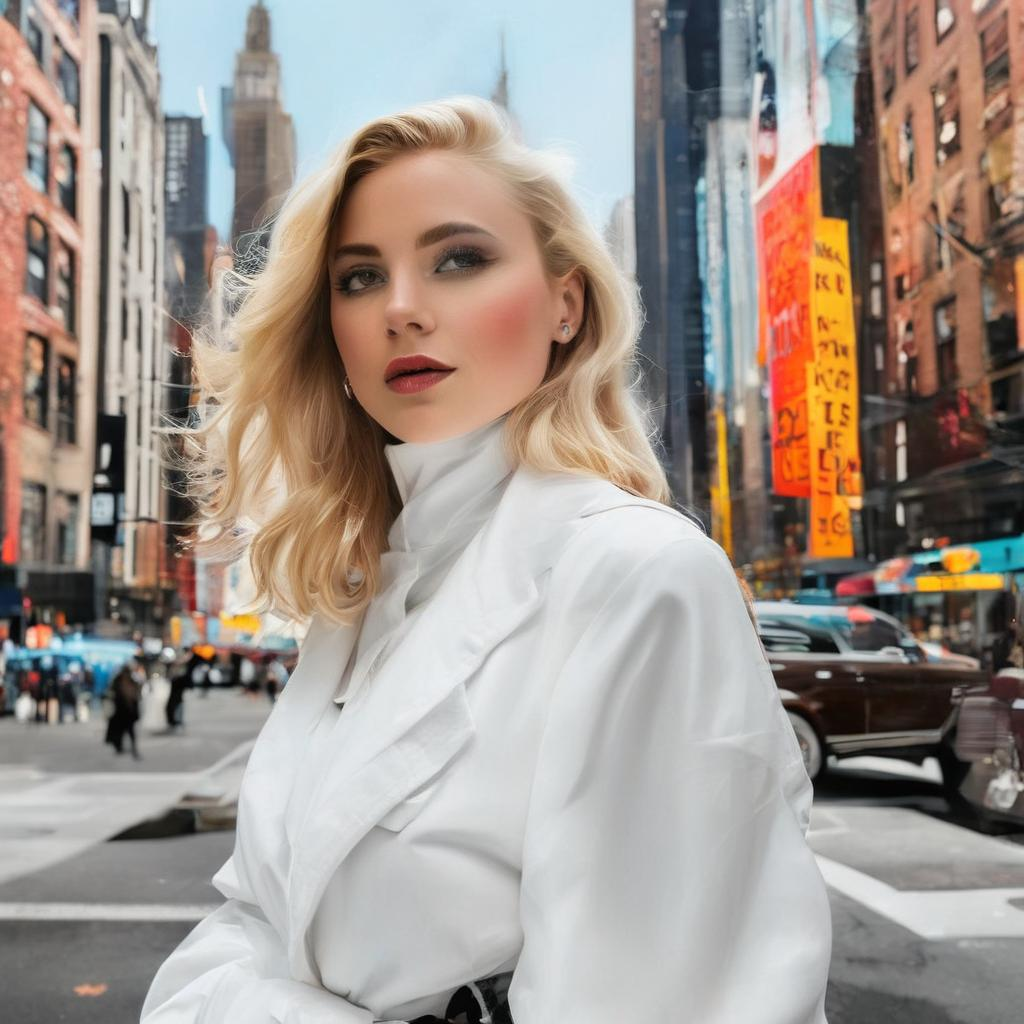

In [16]:
from diffusers.utils import load_image

image = load_image(
    "/content/test (1).jpg"
)
image


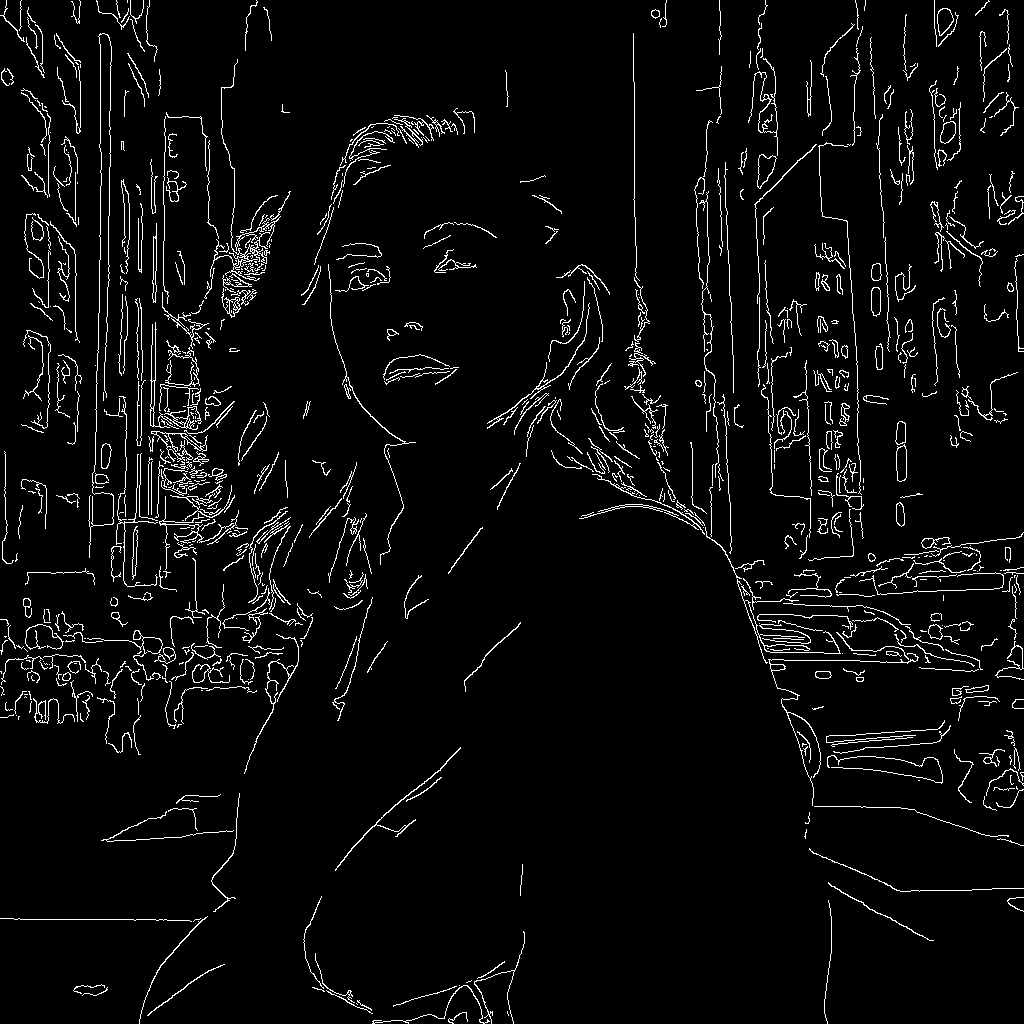

In [17]:
import cv2
from PIL import Image
import numpy as np

image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
canny_image


In [18]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [19]:
from diffusers import UniPCMultistepScheduler

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)


In [20]:
pipe.enable_model_cpu_offload()


In [21]:
pipe.enable_xformers_memory_efficient_attention()


In [22]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


In [25]:
prompt = ", best quality, extremely detailed"
prompt = [t + prompt for t in ["Priyanka Chopra", "Taylor Swift", "Deepika Padukone" ,"Emma Watson"]]
generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(len(prompt))]


  0%|          | 0/20 [00:00<?, ?it/s]

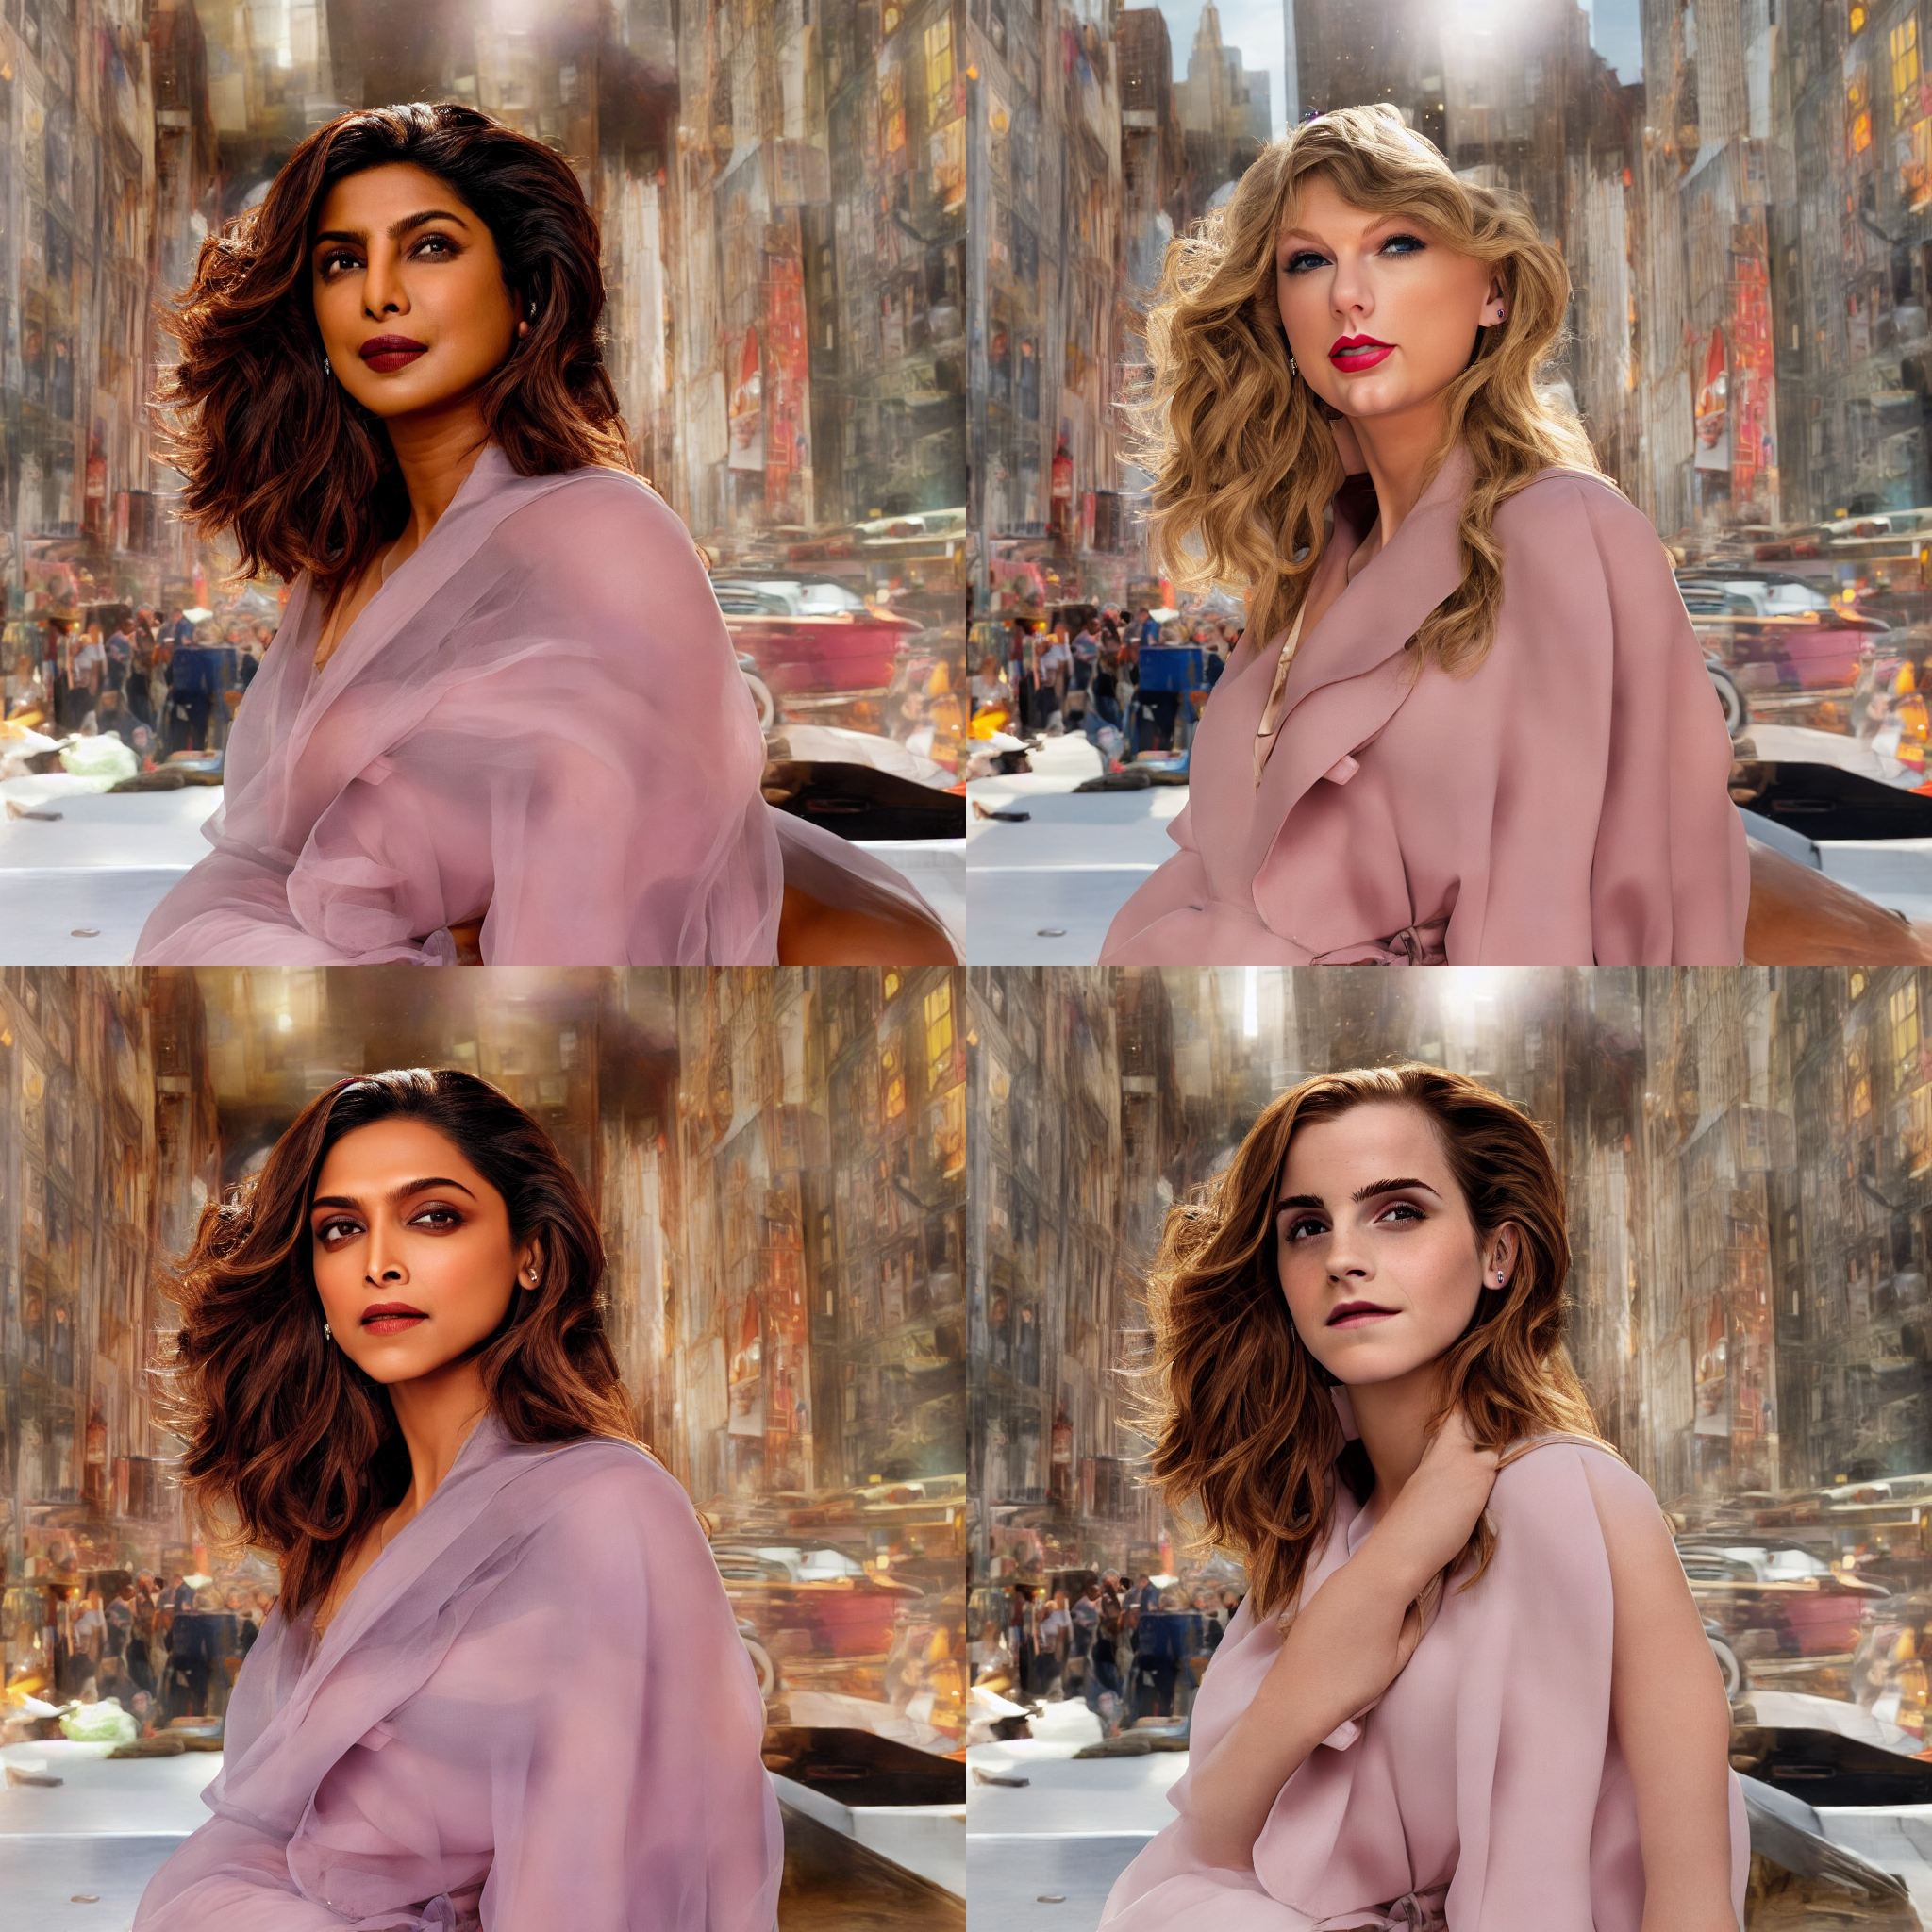

In [26]:
output = pipe(
    prompt,
    canny_image,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality,ugly, poorly Rendered face, low resolution"] * 4,
    num_inference_steps=20,
    generator=generator,
)

image_grid(output.images, 2, 2)
